In [1]:
import json
import numpy as np
import pandas as pd 
import re

In [2]:
file_dir = 'wikipedia-movies.json'

In [3]:
with open(file_dir, mode='r') as file:
    wiki_movies_raw = json.load(file)

In [4]:
kaggle_metadata = pd.read_csv('archive/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv('archive/ratings.csv')

In [5]:
wiki_movies_df = pd.DataFrame(wiki_movies_raw)

In [6]:
wiki_movies = [
    movie for movie in wiki_movies_raw
    if ('Director' in movie or 'Directed by' in movie)
    and 'imdb_link' in movie
    and 'No. of episodes' not in movie
] 

In [7]:
def clean_movie(movie):
    '''
    This function takes in a movie from our 'wikipedia-movies.json'. 
    If one or more alternate titles exist, those are added to a new 'alt_title' key, which will manifest as a column in our subsequently created wiki_movies_df DataFrame. 
    Additionally, it will take remove redundant columns, adding the value to the desired new column name. 
    It returns the cleaned-up movie dictionary. 
    '''
    movie = dict(movie)
    
    alt_titles = {}
    alt_title_keys =[    
        'Also known as','Arabic','Cantonese','Chinese','French',
        'Hangul','Hebrew','Hepburn','Japanese','Literally',
        'Mandarin','McCune–Reischauer','Original title','Polish',
        'Revised Romanization','Romanized','Russian',
        'Simplified','Traditional','Yiddish'
    ]
    for key in alt_title_keys:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
            
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles
        
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    
    # a list of column names to use with change_column_name(); each tuple is the old name and the desired new name, respectively 
    column_names_to_change = [
        ('Adaptation by', 'Writer(s)'), ('Country of origin', 'Country'), ('Directed by', 'Director'), 
        ('Distributed by', 'Distributor'), ('Edited by', 'Editor(s)'), ('Length', 'Running time'), 
        ('Original release', 'Release date'), ('Music by', 'Composer(s)'), ('Produced by', 'Producer(s)'), 
        ('Producer', 'Producer(s)'), ('Productioncompanies ', 'Production company(s)'), ('Productioncompany ', 'Production company(s)'),
        ('Released', 'Release Date'), ('Release Date', 'Release date'), ('Screen story by', 'Writer(s)'), 
        ('Screenplay by', 'Writer(s)'), ('Story by', 'Writer(s)'), ('Theme music composer', 'Composer(s)'), 
        ('Written by', 'Writer(s)')
    ]
    
    for old_name, new_name in column_names_to_change:
        change_column_name(old_name, new_name)
        
    return movie

In [8]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]

In [9]:
wiki_movies_df = pd.DataFrame(clean_movies)

In [10]:
# review columns
sorted(wiki_movies_df.columns.tolist())

['Animation by',
 'Audio format',
 'Based on',
 'Box office',
 'Budget',
 'Cinematography',
 'Color process',
 'Composer(s)',
 'Country',
 'Created by',
 'Director',
 'Distributor',
 'Editor(s)',
 'Executive producer(s)',
 'Followed by',
 'Genre',
 'Label',
 'Language',
 'Narrated by',
 'Original language(s)',
 'Original network',
 'Picture format',
 'Preceded by',
 'Producer(s)',
 'Production company(s)',
 'Production location(s)',
 'Recorded',
 'Release date',
 'Running time',
 'Starring',
 'Suggested by',
 'Venue',
 'Voices of',
 'Writer(s)',
 'alt_titles',
 'imdb_link',
 'title',
 'url',
 'year']

In [11]:
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')

In [12]:
print(len(wiki_movies_df))
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))

7076
7033


In [13]:
# get a count of null values for each column
[[column, wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]

[['url', 0],
 ['year', 0],
 ['imdb_link', 0],
 ['title', 1],
 ['Based on', 4852],
 ['Starring', 184],
 ['Narrated by', 6752],
 ['Cinematography', 691],
 ['Release date', 32],
 ['Running time', 139],
 ['Country', 236],
 ['Language', 244],
 ['Budget', 2295],
 ['Box office', 1548],
 ['Director', 0],
 ['Distributor', 357],
 ['Editor(s)', 548],
 ['Composer(s)', 518],
 ['Producer(s)', 202],
 ['Production company(s)', 1678],
 ['Writer(s)', 199],
 ['Genre', 6923],
 ['Original language(s)', 6875],
 ['Original network', 6908],
 ['Executive producer(s)', 6936],
 ['Production location(s)', 6986],
 ['Picture format', 6969],
 ['Audio format', 6972],
 ['Voices of', 7031],
 ['Followed by', 7024],
 ['Created by', 7023],
 ['Preceded by', 7023],
 ['Suggested by', 7032],
 ['alt_titles', 7012],
 ['Recorded', 7031],
 ['Venue', 7032],
 ['Label', 7031],
 ['Animation by', 7031],
 ['Color process', 7032],
 ['imdb_id', 0]]

In [14]:
# get columns that have less than 90% null values; update the wiki_movies_df
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < (len(wiki_movies_df) * 0.9)]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [15]:
# review the remaining columns
sorted(wiki_movies_df.columns.tolist())

['Based on',
 'Box office',
 'Budget',
 'Cinematography',
 'Composer(s)',
 'Country',
 'Director',
 'Distributor',
 'Editor(s)',
 'Language',
 'Producer(s)',
 'Production company(s)',
 'Release date',
 'Running time',
 'Starring',
 'Writer(s)',
 'imdb_id',
 'imdb_link',
 'title',
 'url',
 'year']

In [16]:
# clean box office data
box_office = wiki_movies_df['Box office'].dropna()

In [17]:
# define a function to let us know whether a value is not a string
def is_not_a_string(x):
    return type(x) != str

In [18]:
# map above function to box_office
box_office[box_office.map(is_not_a_string)]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
74                    [$6,488,144, (US), [1]]
126                [US$1,531,489, (domestic)]
130                          [US$, 4,803,039]
                        ...                  
6980               [$99.6, million, [4], [5]]
6994                   [$365.6, million, [1]]
6995                         [$53.8, million]
7015                     [$435, million, [7]]
7048                   [$529.3, million, [4]]
Name: Box office, Length: 135, dtype: object

In [19]:
# on second though, let's use a lambda function instead
box_office[box_office.map(lambda x: type(x) != str)]

# convert lists to strings
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)

In [20]:
# our two regex forms for values; see 'misc/notes.txt' for details, if needed
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'

In [21]:
# count how many box office values match form_one, form_two
box_office_matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE, na=False)
box_office_matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE, na=False)

In [22]:
box_office[~box_office_matches_form_one & ~box_office_matches_form_two]

110              $4.35-4.37 million
600                      $5000 (US)
1070                     35,254,617
1480                     £3 million
1865                   ¥1.1 billion
2032                            N/A
2091                           $309
2665    926,423 admissions (France)
3088      $32 [2] –33.1 million [1]
3631                            TBA
3859             $38.9–40.3 million
3879       CN¥3.650 million (China)
4116                     £7,385,434
4261             $20.7–23.9 million
4306                         $20-30
4561        $45.2k (only in Turkey)
5447                          £2.56
5784                       413 733$
6013                        Unknown
6145             $17.5–18.4 million
6234             $41.8–41.9 million
6369                          $111k
6370                           $588
6593                 less than $372
6843                        8 crore
Name: Box office, dtype: object

In [23]:
# some values are given as a range - to solve this, search for any string that starts with a dollar sign and ends with a hyphen, then replace it with just a dollar sign
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [24]:
# extract and convert the box office values}
box_office.str.extract(f'({form_one}|{form_two})')

,0
0,$21.4 million
1,$2.7 million
2,"$57,718,089"
3,"$7,331,647"
4,"$6,939,946"
...,...
7070,$19.4 million
7071,$41.9 million
7072,$76.1 million
7073,$38.4 million


In [25]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):
        pass
        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):
        pass

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):
        pass
        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [26]:
# apply the parse_dollars() function to box_office and add the column to the wiki_movies_df
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

# drop the unnecessary 'Box office' column
wiki_movies_df.drop('Box office', axis=1, inplace=True)

In [27]:
# parse budget data
budget = wiki_movies_df['Budget'].dropna()

# convert lists to strings
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

# remove any values between a dollar sign and a hyphen
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [28]:
# use the same, previously created regex patterns for budget
budget_matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE, na=False)
budget_matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE, na=False)

# remove citation references, e.g. "$34 [3] [4] million"
budget = budget.str.replace(r'\[\d+\]\s*', '')

budget[~budget_matches_form_one & ~budget_matches_form_two]

/Users/timnilsen/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973                     $34 million
1126                   $120 million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360                   $150 million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034                  $$200 million
5055                   $155 million
5419                    $40 

In [29]:
# apply parse_dollars() to budget
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

# drop the original, unecessary 'Budget' column
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [30]:
# parse release date

# create a variable that holds non-null values, convert lists to strings
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [31]:
# define our date_form regex patterns
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[0123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

In [32]:
# set new 'release_date' column 
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

In [33]:
# parse Running Time

# convert lists to strings
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE, na=False) != True]

9                                                 102 min
26                                                 93 min
28                                                32 min.
34                                                101 min
35                                                 97 min
                              ...                        
6500       114 minutes [1] 120 minutes (extended edition)
6643                                             104 mins
6709    90 minutes (theatrical) [1] 91 minutes (unrate...
7057    108 minutes (Original cut) 98 minutes (UK cut)...
7075                Variable; 90 minutes for default path
Name: Running time, Length: 366, dtype: object

In [34]:
# extract the running time groups
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')

In [35]:
# set values to numeric
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)

In [36]:
# apply a function to convert the hour groups and minute groups to minutes if the pure minutes group is zero
# save to a new 'running_time' column
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)

In [37]:
# drop original 'Running time' column
wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [38]:
# clean Kaggle data

kaggle_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [39]:
# remove bad data
kaggle_metadata[~kaggle_metadata['adult'].isin(['True', 'False'])]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# let's keep rows where the 'adult' column is False, then drop the 'adult' column
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult', axis='columns')

In [41]:
# next, let's look at the values of the 'video' column
kaggle_metadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [42]:
# convert datatypes for 'video'
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

In [43]:
# convert necessary columns to numeric datatypes; use errors='raise' to ensure we're aware if any data cannot be converted
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [44]:
# convert 'release_date' to datetime
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])

In [46]:
# let's take a look at ratings data
ratings.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [47]:
# convert ratings' timestamp
pd.to_datetime(ratings['timestamp'], unit='s')

0          2015-03-09 22:52:09
1          2015-03-09 23:07:15
2          2015-03-09 22:52:03
3          2015-03-09 22:52:26
4          2015-03-09 22:52:36
                   ...        
26024284   2009-10-31 23:26:04
26024285   2009-10-31 23:33:52
26024286   2009-10-31 23:29:24
26024287   2009-11-01 00:06:30
26024288   2009-10-31 23:30:58
Name: timestamp, Length: 26024289, dtype: datetime64[ns]

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

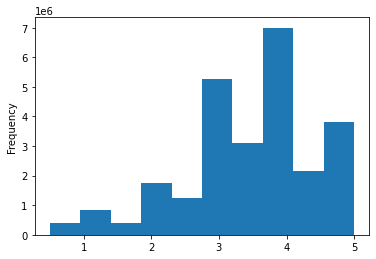

In [48]:
# plot a histogram of rating data
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()